# REGRESSION MULTI MODEL

Great! The **multiple models per time segment** approach is super useful when:

- Your data has **non-stationary behavior** — meaning patterns **change dramatically at different times of the day**.
- You’ve already noticed large prediction errors during **certain time windows** (like 10:15 AM, 11 AM, 3 PM, 4 PM), suggesting that **one global model can't generalize well** across all segments.

---

### 🧠 What Is the Idea?

Instead of training one model to cover the whole day, you **split the data into meaningful time windows** (segments), and train a **separate model for each segment**. This allows each model to **focus on learning the specific patterns** and student behavior unique to that time of day.

---

### 🕒 Example Segmentation

You could segment by:

| Segment Name | Time Slot Range (minutes) | Description |
|--------------|---------------------------|-------------|
| Morning      | 600–690 (10:00–11:30)     | Underpredicts a lot |
| Midday       | 700–780 (11:40–1:00)      | Slight over |
| Afternoon    | 790–870 (1:10–2:50)       | Mixed swings |
| Peak PM      | 880–960 (3:00–4:40)       | Underpredicts heavily |
| Other        | Rest of the day           | Mostly accurate |

You can adjust those ranges based on your domain knowledge and error analysis.

---

### ⚙️ How It Works

1. **Segment your training data** by `time_slot_minutes` using `pandas` filters.
2. For each segment:
   - Train a **separate model** (can be the same algorithm like `XGBRegressor`, or different ones).
   - Save the model with a name like `"xgb_model_morning.pkl"`.
3. During prediction:
   - Based on the input's `time_slot_minutes`, select the **corresponding model**.
   - Run the prediction using that model.

---

### ✅ Advantages

- **Higher accuracy** during peaks and valleys.
- Models can better learn **nuances and capacity issues** of different times.
- Easier to debug or tune — each model is smaller and more focused.

---

### 🚧 Challenges

- You need **enough training samples** per segment.
- Slight increase in complexity for model selection and deployment.
- Edge cases: time slots on the border (e.g. 690 or 700) might be trickier to place.

---

### 💡 Optimization Tips

- Use the **same feature pipeline** for all segments to avoid inconsistency.
- Add a `"segment"` column to the data to help label and group.
- Start with **2-3 segments** and scale only if performance improves.

---

Would you like help splitting your data and training the first couple of models? We could try it out for, say, the **Morning** and **Afternoon** segments first.

In [1]:
import pandas as pd
import sqlite3
from data_collections.constants import SQLITE_DATABASE_MODEL

In [2]:
TABLE_NAME = "course_info" 

In [3]:
connection = sqlite3.connect(SQLITE_DATABASE_MODEL)
c = connection.cursor()

In [4]:
obs_data = pd.read_sql_query(f'SELECT * FROM {TABLE_NAME}', connection)

In [5]:
data = obs_data.copy()

## skip all above

In [6]:
data = pd.read_csv('class_model.csv')

In [7]:
data.head()

,faculty_code,faculty,course_code,course_name,class,teacher,year,day,start_time,end_time,student_nums
0,GÖRSEL İLETİŞİM TASARIMI_GSF102,GÖRSEL İLETİŞİM TASARIMI,GSF102,TEMEL TASARIM II,L-102(GİT ATÖLYE II)[60],SEÇİL KARTOPU,1,Pazartesi,09:00,14:50,41
1,GÖRSEL İLETİŞİM TASARIMI_GSF106,GÖRSEL İLETİŞİM TASARIMI,GSF106,ÇİZİM II,L-101(GİT ATÖLYE I)[60],Öğr.Gör. İSMAİL FURKAN YAVUZ,1,Pazartesi,09:00,14:50,44
2,GÖRSEL İLETİŞİM TASARIMI_BLG102,GÖRSEL İLETİŞİM TASARIMI,BLG102,BİLGİ TEKNOLOJİLERİ KULLANIMI,AZ 13(BİLGİSAYAR LAB.)[80],Öğr.Gör. AHMET AKSOY,1,Salı,09:00,15:20,44
3,İKTİSAT_ENG104,İKTİSAT,ENG104,ACADEMIC ENGLISH II,B382(KONFERANS SALONU)[143],Öğr.Gör. MÜGE AKGEDİK AKOĞLANOĞLU,1,Pazartesi,09:00,16:20,35
4,İKTİSAT_ECON102,İKTİSAT,ECON102,INTRODUCTION TO ECONOMICS II,B338-D1(DERSLİK1)[121],KORAY GÖKSAL,1,Pazartesi,14:00,16:20,91


In [8]:
print(f'there are {len(data.columns)} columns and {len(data)} rows')

there are 11 columns and 572 rows


### STEP 1: structure the data for the model

In [9]:
# list all the columns to drop

print(data.columns)

Index(['faculty_code', 'faculty', 'course_code', 'course_name', 'class',
       'teacher', 'year', 'day', 'start_time', 'end_time', 'student_nums'],
      dtype='object')


In [10]:
to_drop = ['faculty_code', 'faculty', 'course_name', 'class', 'year', 'start_time']

In [11]:
data.drop(labels=to_drop,axis=1, inplace=True)

In [12]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [13]:
import pandas as pd
from datetime import datetime, timedelta

def calculate_bus_stop_counts(df):
    """
    Takes a class schedule DataFrame and returns a new DataFrame with time slots and bus_stop_count.
    Works using minutes-from-midnight as time representation.
    
    Required columns in df:
    - 'day' (e.g., Monday)
    - 'end_time' (string in 'HH:MM' format)
    - 'student_nums' (integer)
    """
    
    # Convert end_time to datetime for parsing, then extract minutes-from-midnight
    df['end_time'] = pd.to_datetime(df['end_time'], format='%H:%M')
    df['end_time_minutes'] = df['end_time'].dt.hour * 60 + df['end_time'].dt.minute
    
    time_slots = []

    for _, row in df.iterrows():
        end_time_min = row['end_time_minutes']
        student_count = row['student_nums']
        day = row['day']
        
        # Define departure distribution
        departures = [
            (0, 0.20),  # 0-5 minutes
            (5, 0.50),  # 5-10 minutes
            (10, 0.30)  # 10-15 minutes
        ]

        for offset, fraction in departures:
            slot_min = end_time_min + offset  # Still in minutes-from-midnight
            time_slots.append({
                'day': day,
                'time_slot_minutes': slot_min,
                'bus_stop_count': int(student_count * fraction)
            })

    # Create DataFrame from list of time slots
    result_df = pd.DataFrame(time_slots)

    # Group by day and time slot to sum overlapping students
    result_df = result_df.groupby(['day', 'time_slot_minutes'], as_index=False).sum()
    #result_df['time_slot'] = result_df['time_slot_minutes'].apply(lambda x: f"{x // 60:02}:{x % 60:02}")


    return result_df


In [14]:
data = calculate_bus_stop_counts(data)
print(data)

          day  time_slot_minutes  bus_stop_count
0        Cuma                650              30
1        Cuma                655              78
2        Cuma                660              46
3        Cuma                710              91
4        Cuma                715             232
..        ...                ...             ...
145  Çarşamba                985             488
146  Çarşamba                990             288
147  Çarşamba               1070              25
148  Çarşamba               1075              63
149  Çarşamba               1080              37

[150 rows x 3 columns]


next encoding

In [15]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# one hot encoding for the days column
## we commented it out because the randomforestclassifier does not need one hot encoding

In [16]:
"""
days = pd.get_dummies(data['day'], prefix='day')
new_drop = ['day']
data.drop(labels=new_drop, axis=1, inplace=True)
_d = days.apply(le.fit_transform)
data = data.join(_d)
"""

"\ndays = pd.get_dummies(data['day'], prefix='day')\nnew_drop = ['day']\ndata.drop(labels=new_drop, axis=1, inplace=True)\n_d = days.apply(le.fit_transform)\ndata = data.join(_d)\n"

In [17]:
data

,day,time_slot_minutes,bus_stop_count
0,Cuma,650,30
1,Cuma,655,78
2,Cuma,660,46
3,Cuma,710,91
4,Cuma,715,232
...,...,...,...
145,Çarşamba,985,488
146,Çarşamba,990,288
147,Çarşamba,1070,25
148,Çarşamba,1075,63


In [18]:
data.to_csv('day_time_stop.csv')

In [19]:
le = LabelEncoder()

In [20]:
data['day_encoded'] = le.fit_transform(data['day'])

In [21]:
data = data.drop(columns=['day'])


In [22]:
data

,time_slot_minutes,bus_stop_count,day_encoded
0,650,30,0
1,655,78,0
2,660,46,0
3,710,91,0
4,715,232,0
...,...,...,...
145,985,488,4
146,990,288,4
147,1070,25,4
148,1075,63,4


add segemnts:
-------
12 am - 8 am --> 0 - 480 = morning
-------
8 am - 2 pm --> 480 - 840 = noon
-------
2 pm - 7 pm --> 840 - 1140 = evening
-------
7 pm - 12 am --> 1140 - 0 = night
-------

In [23]:
def add_segments(df):

    segments = [0, 1, 2, 3]

    sad = []
    tsm = df['time_slot_minutes']

    for i, t in enumerate(tsm):

        if (tsm[i] >= 0) and (tsm[i] < 480):

            sad.append(segments[0])
        elif (tsm[i] >= 480) and (tsm[i] < 840):

            sad.append(segments[1])
        elif (tsm[i] >= 840) and (tsm[i] < 1140):

            sad.append(segments[2])
        elif (tsm[i] >= 1140) and (tsm[i] < 1440):

            sad.append(segments[3])

    df['segment'] = sad
    return df

In [24]:
data = add_segments(data)

In [25]:
data

,time_slot_minutes,bus_stop_count,day_encoded,segment
0,650,30,0,1
1,655,78,0,1
2,660,46,0,1
3,710,91,0,1
4,715,232,0,1
...,...,...,...,...
145,985,488,4,2
146,990,288,4,2
147,1070,25,4,2
148,1075,63,4,2


In [26]:
morning_data = data.loc[data['segment'] == 0].drop(labels='segment', axis=1)
noon_data = data.loc[data['segment'] == 1].drop(labels='segment', axis=1)
evening_data = data.loc[data['segment'] == 2].drop(labels='segment', axis=1)
night_data = data.loc[data['segment'] == 3].drop(labels='segment', axis=1)

In [95]:
noon_data.to_csv('regression_noon_model_data.csv', index=False)

In [96]:
evening_data.to_csv('regression_evening_model_data.csv', index=False)

only noon and evening have data

## model imports

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import xgboost as xgb

## noon models

In [30]:
noon_X = noon_data.drop(labels=['bus_stop_count'], axis=1)
noon_y = noon_data['bus_stop_count']

In [31]:
noon_X_train, noon_X_test, noon_y_train, noon_y_test = train_test_split(noon_X, noon_y, test_size=0.2, random_state=42)

In [32]:
noon_model = RandomForestRegressor(n_estimators=50)
noon_model.fit(noon_X_train, noon_y_train)
noon_y_predict = noon_model.predict(noon_X_test)
print('Noon - RandomForestRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(noon_y_test, noon_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(noon_y_test, noon_y_predict)}')
print(f'mean squared error = {mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'r2 score = {r2_score(noon_y_test, noon_y_predict)}')

Noon - RandomForestRegressor:

mean absolute error = 60.660000000000004
mean absolute percentage error = 1.0687658704653773
mean squared error = 9660.666350000003
root mean squared error = 98.28868882022999
r2 score = 0.46420593129329246


In [85]:
noon_model = GradientBoostingRegressor(random_state=9,n_estimators=300, learning_rate=0.3, max_depth=5, subsample=0.8)
noon_model.fit(noon_X_train, noon_y_train)
noon_y_predict = noon_model.predict(noon_X_test)
print('Noon - GradientBoostingRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(noon_y_test, noon_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(noon_y_test, noon_y_predict)}')
print(f'mean squared error = {mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'r2 score = {r2_score(noon_y_test, noon_y_predict)}')

Noon - GradientBoostingRegressor:

mean absolute error = 21.280019752943858
mean absolute percentage error = 0.34464865306191106
mean squared error = 883.5365035530037
root mean squared error = 29.72434193641642
r2 score = 0.950997829659073


In [86]:
"""
logs = open('models.txt', 'a', encoding='utf-8')
for i in range(1, 100):
    
    noon_model = GradientBoostingRegressor(random_state=i, n_estimators=300, learning_rate=0.3, max_depth=5, subsample=0.8)
    noon_model.fit(noon_X_train, noon_y_train)
    noon_y_predict = noon_model.predict(noon_X_test)
    print(f'random_state = {i}')
    logs.write(f'random_state = {i}\n')
    print('Noon - GradientBoostingRegressor:\n')
    logs.write('Noon - GradientBoostingRegressor:\n')
    print(f'mean absolute error = {mean_absolute_error(noon_y_test, noon_y_predict)}')
    logs.write(f'mean absolute error = {mean_absolute_error(noon_y_test, noon_y_predict)}\n')
    print(f'mean absolute percentage error = {mean_absolute_percentage_error(noon_y_test, noon_y_predict)}')
    logs.write(f'mean absolute percentage error = {mean_absolute_percentage_error(noon_y_test, noon_y_predict)}\n')
    print(f'mean squared error = {mean_squared_error(noon_y_test, noon_y_predict)}')
    logs.write(f'mean squared error = {mean_squared_error(noon_y_test, noon_y_predict)}\n')
    print(f'root mean squared error = {root_mean_squared_error(noon_y_test, noon_y_predict)}')
    logs.write(f'root mean squared error = {root_mean_squared_error(noon_y_test, noon_y_predict)}\n')
    print(f'r2 score = {r2_score(noon_y_test, noon_y_predict)}')
    logs.write(f'r2 score = {r2_score(noon_y_test, noon_y_predict)}\n')
"""

"\nlogs = open('models.txt', 'a', encoding='utf-8')\nfor i in range(1, 100):\n\n    noon_model = GradientBoostingRegressor(random_state=i, n_estimators=300, learning_rate=0.3, max_depth=5, subsample=0.8)\n    noon_model.fit(noon_X_train, noon_y_train)\n    noon_y_predict = noon_model.predict(noon_X_test)\n    print(f'random_state = {i}')\n    logs.write(f'random_state = {i}\n')\n    print('Noon - GradientBoostingRegressor:\n')\n    logs.write('Noon - GradientBoostingRegressor:\n')\n    print(f'mean absolute error = {mean_absolute_error(noon_y_test, noon_y_predict)}')\n    logs.write(f'mean absolute error = {mean_absolute_error(noon_y_test, noon_y_predict)}\n')\n    print(f'mean absolute percentage error = {mean_absolute_percentage_error(noon_y_test, noon_y_predict)}')\n    logs.write(f'mean absolute percentage error = {mean_absolute_percentage_error(noon_y_test, noon_y_predict)}\n')\n    print(f'mean squared error = {mean_squared_error(noon_y_test, noon_y_predict)}')\n    logs.write(f'

random_state = 9
Noon - GradientBoostingRegressor:
mean absolute error = 21.280019752943858
mean absolute percentage error = 0.34464865306191106
mean squared error = 883.5365035530037
root mean squared error = 29.72434193641642
r2 score = 0.950997829659073

random_state = 18
Noon - GradientBoostingRegressor:
mean absolute error = 25.054809653268002
mean absolute percentage error = 0.35867854746476313
mean squared error = 1706.2372763915005
root mean squared error = 41.306625090795066
r2 score = 0.905369694038046

random_state = 72
Noon - GradientBoostingRegressor:
mean absolute error = 26.81264387018733
mean absolute percentage error = 0.6478380305582344
mean squared error = 2034.1852652559555
root mean squared error = 45.101943031935505
r2 score = 0.8871812398557041

random_state = 74
Noon - GradientBoostingRegressor:
mean absolute error = 27.754339885463104
mean absolute percentage error = 0.42162807193320706
mean squared error = 2159.3570751356556
root mean squared error = 46.46888286946067
r2 score = 0.8802390361946877

<Axes: xlabel='time_slot_minutes'>

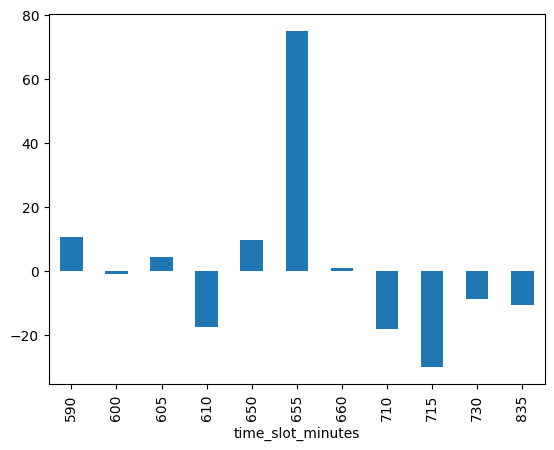

In [87]:
df_results = noon_X_test.copy()
df_results["actual"] = noon_y_test
df_results["predicted"] = noon_y_predict
df_results["error"] = df_results["actual"] - df_results["predicted"]

# Example: error trend by time slot
df_results.groupby("time_slot_minutes")["error"].mean().plot(kind='bar')

In [94]:
noon_data.to_csv('regression_noon_model_data1.csv')

overpredicts by 70 at 10:55 am

In [91]:
ggg = noon_data.loc[(noon_data['time_slot_minutes'] == 725) & (noon_data['day_encoded'] == 0)]
time_slot_minutes =[713]
day_encoded = [0]
noon_new_data = pd.DataFrame({'time_slot_minutes': time_slot_minutes, 'day_encoded':day_encoded})
noon_new_pred = noon_model.predict(noon_new_data)

In [92]:
ggg

,time_slot_minutes,bus_stop_count,day_encoded


In [93]:
noon_new_pred

array([262.19861649])

In [39]:
noon_model = LinearRegression()
noon_model.fit(noon_X_train, noon_y_train)
noon_y_predict = noon_model.predict(noon_X_test)
print('Noon - LinearRegression:\n')
print(f'mean absolute error = {mean_absolute_error(noon_y_test, noon_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(noon_y_test, noon_y_predict)}')
print(f'mean squared error = {mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'r2 score = {r2_score(noon_y_test, noon_y_predict)}')

Noon - LinearRegression:

mean absolute error = 122.83562609266853
mean absolute percentage error = 4.207787114678406
mean squared error = 18430.12312697782
root mean squared error = 135.7575895741296
r2 score = -0.022160407906958834


In [40]:
noon_model = PoissonRegressor()
noon_model.fit(noon_X_train, noon_y_train)
noon_y_predict = noon_model.predict(noon_X_test)
print('Noon - PoissonRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(noon_y_test, noon_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(noon_y_test, noon_y_predict)}')
print(f'mean squared error = {mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'r2 score = {r2_score(noon_y_test, noon_y_predict)}')

Noon - PoissonRegressor:

mean absolute error = 136.6484375
mean absolute percentage error = 5.0310837579134855
mean squared error = 23158.46118164063
root mean squared error = 152.17904317494123
r2 score = -0.2844006502199068


c:\Users\Owner\miniconda3\envs\senior\Lib\site-packages\sklearn\linear_model\_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


In [41]:
noon_model = GaussianProcessRegressor(alpha=0.3)
noon_model.fit(noon_X_train, noon_y_train)
noon_y_predict = noon_model.predict(noon_X_test)
print('Noon - GaussianProcessRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(noon_y_test, noon_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(noon_y_test, noon_y_predict)}')
print(f'mean squared error = {mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'r2 score = {r2_score(noon_y_test, noon_y_predict)}')

Noon - GaussianProcessRegressor:

mean absolute error = 79.15260367829282
mean absolute percentage error = 0.688616534133842
mean squared error = 14211.635228780104
root mean squared error = 119.21256321705403
r2 score = 0.21180283157137814


In [42]:
noon_model = xgb.XGBRegressor(random_state=42)
noon_model.fit(noon_X_train, noon_y_train)
noon_y_predict = noon_model.predict(noon_X_test)
print('Noon - XGBRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(noon_y_test, noon_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(noon_y_test, noon_y_predict)}')
print(f'mean squared error = {mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'r2 score = {r2_score(noon_y_test, noon_y_predict)}')

Noon - XGBRegressor:

mean absolute error = 56.533809661865234
mean absolute percentage error = 0.9012734889984131
mean squared error = 15683.7060546875
root mean squared error = 125.23460388183594
r2 score = 0.13015973567962646


<Axes: xlabel='time_slot_minutes'>

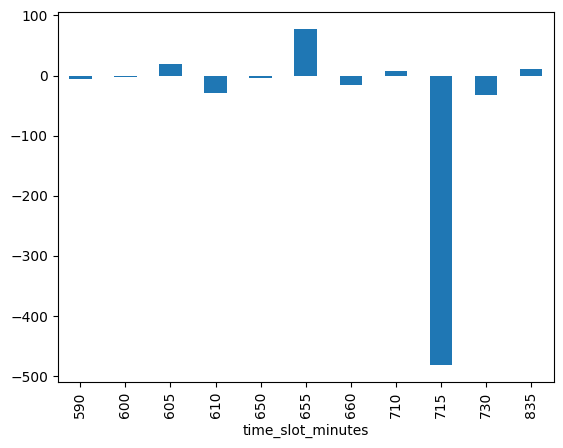

In [43]:
df_results = noon_X_test.copy()
df_results["actual"] = noon_y_test
df_results["predicted"] = noon_y_predict
df_results["error"] = df_results["actual"] - df_results["predicted"]

# Example: error trend by time slot
df_results.groupby("time_slot_minutes")["error"].mean().plot(kind='bar')

In [44]:
ggg = noon_data.loc[(noon_data['time_slot_minutes'] == 725) & (noon_data['day_encoded'] == 0)]
time_slot_minutes =[713]
day_encoded = [0]
noon_new_data = pd.DataFrame({'time_slot_minutes': time_slot_minutes, 'day_encoded':day_encoded})
noon_new_pred = noon_model.predict(noon_new_data)

In [45]:
ggg

,time_slot_minutes,bus_stop_count,day_encoded


In [46]:
noon_new_pred

array([91.00484], dtype=float32)

Noon - XGBRegressor:

mean absolute error = 100.11380004882812
mean absolute percentage error = 1.9931617975234985
mean squared error = 36014.6484375
root mean squared error = 189.77525329589844
r2 score = -0.9974228143692017


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

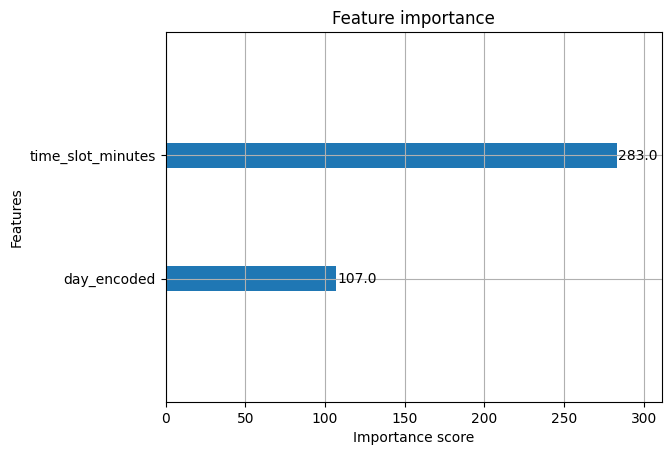

In [47]:
noon_model = xgb.XGBRegressor(
    n_estimators=50,
    learning_rate=0.5,
    max_depth=60,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_alpha=0.3,
    reg_lambda=1.0
)
noon_model.fit(noon_X_train, noon_y_train)
noon_y_predict = noon_model.predict(noon_X_test)
print('Noon - XGBRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(noon_y_test, noon_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(noon_y_test, noon_y_predict)}')
print(f'mean squared error = {mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(noon_y_test, noon_y_predict)}')
print(f'r2 score = {r2_score(noon_y_test, noon_y_predict)}')
from xgboost import plot_importance
plot_importance(noon_model)


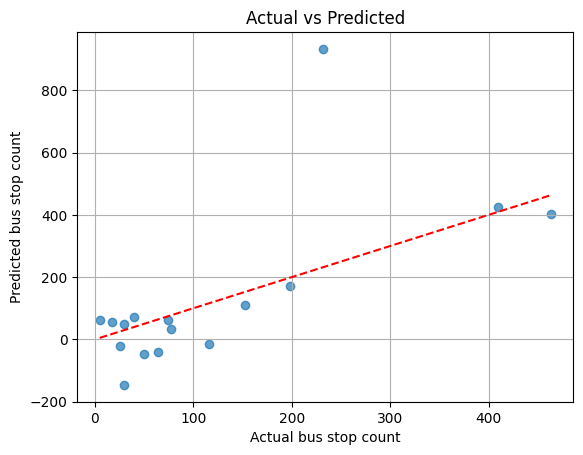

In [48]:
import matplotlib.pyplot as plt

plt.scatter(noon_y_test, noon_y_predict, alpha=0.7)
plt.plot([noon_y_test.min(), noon_y_test.max()], [noon_y_test.min(), noon_y_test.max()], 'r--')
plt.xlabel("Actual bus stop count")
plt.ylabel("Predicted bus stop count")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()


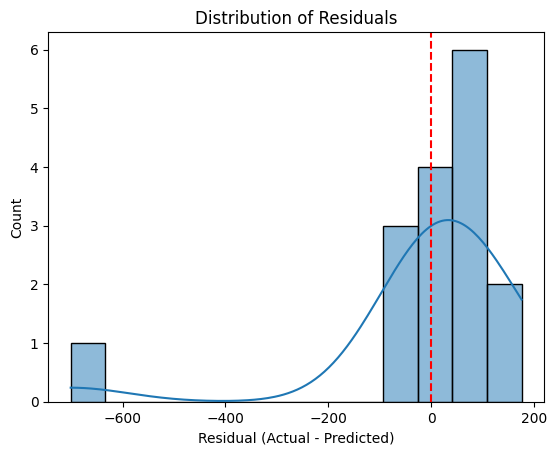

In [49]:
import seaborn as sns
import pandas as pd

residuals = noon_y_test - noon_y_predict
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.axvline(0, color='red', linestyle='--')
plt.show()


In [50]:
print("Mean residual:", residuals.mean())


Mean residual: -7.926067769527435


<Axes: xlabel='time_slot_minutes'>

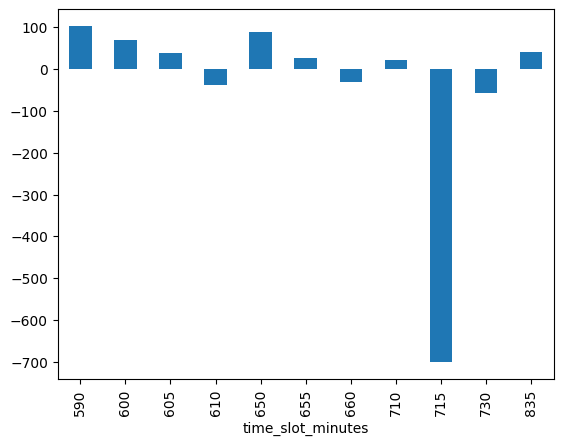

In [51]:
df_results = noon_X_test.copy()
df_results["actual"] = noon_y_test
df_results["predicted"] = noon_y_predict
df_results["error"] = df_results["actual"] - df_results["predicted"]

# Example: error trend by time slot
df_results.groupby("time_slot_minutes")["error"].mean().plot(kind='bar')


In [52]:
time_slot_minutes =[725]
day_encoded = [4]
noon_new_data = pd.DataFrame({'time_slot_minutes': time_slot_minutes, 'day_encoded':day_encoded})
noon_new_pred = noon_model.predict(noon_new_data)

In [53]:
noon_new_pred

array([47.031563], dtype=float32)

## evening models

In [54]:
evening_X = evening_data.drop(labels=['bus_stop_count'], axis=1)
evening_y = evening_data['bus_stop_count']

In [55]:
evening_X_train, evening_X_test, evening_y_train, evening_y_test = train_test_split(evening_X, evening_y, test_size=0.2, random_state=42)

In [56]:
evening_model = RandomForestRegressor(n_estimators=50)
evening_model.fit(evening_X_train, evening_y_train)
evening_y_predict = evening_model.predict(evening_X_test)
print('RandomForestRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(evening_y_test, evening_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(evening_y_test, evening_y_predict)}')
print(f'mean squared error = {mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'r2 score = {r2_score(evening_y_test, evening_y_predict)}')

RandomForestRegressor:

mean absolute error = 127.34714285714286
mean absolute percentage error = 1.0474798886456815
mean squared error = 26162.06054285714
root mean squared error = 161.74690273033713
r2 score = 0.4786885458390405


In [57]:
evening_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.3, max_depth=5, subsample=0.8)
evening_model.fit(evening_X_train, evening_y_train)
evening_y_predict = evening_model.predict(evening_X_test)
print('GradientBoostingRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(evening_y_test, evening_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(evening_y_test, evening_y_predict)}')
print(f'mean squared error = {mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'r2 score = {r2_score(evening_y_test, evening_y_predict)}')

GradientBoostingRegressor:

mean absolute error = 100.79604902595047
mean absolute percentage error = 0.7991430180459252
mean squared error = 22450.553929057212
root mean squared error = 149.83508911152023
r2 score = 0.5526449112712855


In [58]:
evening_model = LinearRegression()
evening_model.fit(evening_X_train, evening_y_train)
evening_y_predict = evening_model.predict(evening_X_test)
print('LinearRegression:\n')
print(f'mean absolute error = {mean_absolute_error(evening_y_test, evening_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(evening_y_test, evening_y_predict)}')
print(f'mean squared error = {mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'r2 score = {r2_score(evening_y_test, evening_y_predict)}')

LinearRegression:

mean absolute error = 198.39868092791366
mean absolute percentage error = 2.8462109018609234
mean squared error = 52179.47262086137
root mean squared error = 228.42826580977533
r2 score = -0.03974060853398398


In [59]:
evening_model = PoissonRegressor()
evening_model.fit(evening_X_train, evening_y_train)
evening_y_predict = evening_model.predict(evening_X_test)
print('PoissonRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(evening_y_test, evening_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(evening_y_test, evening_y_predict)}')
print(f'mean squared error = {mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'r2 score = {r2_score(evening_y_test, evening_y_predict)}')

PoissonRegressor:

mean absolute error = 199.38158109811096
mean absolute percentage error = 2.8364972985840375
mean squared error = 52272.003149355514
root mean squared error = 228.6307134865207
r2 score = -0.04158439389961077


In [60]:
evening_model = GaussianProcessRegressor(alpha=0.3)
evening_model.fit(evening_X_train, evening_y_train)
evening_y_predict = evening_model.predict(evening_X_test)
print('GaussianProcessRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(evening_y_test, evening_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(evening_y_test, evening_y_predict)}')
print(f'mean squared error = {mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'r2 score = {r2_score(evening_y_test, evening_y_predict)}')

GaussianProcessRegressor:

mean absolute error = 119.26289012419672
mean absolute percentage error = 0.619560984150261
mean squared error = 37861.2585750347
root mean squared error = 194.5796972323544
r2 score = 0.24556753732059367


In [113]:
evening_model = xgb.XGBRegressor(random_state=42)
evening_model.fit(evening_X_train, evening_y_train)
evening_y_predict = evening_model.predict(evening_X_test)
print('XGBRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(evening_y_test, evening_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(evening_y_test, evening_y_predict)}')
print(f'mean squared error = {mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'r2 score = {r2_score(evening_y_test, evening_y_predict)}')

XGBRegressor:

mean absolute error = 63.999114990234375
mean absolute percentage error = 0.5602754950523376
mean squared error = 7382.4619140625
root mean squared error = 85.92125701904297
r2 score = 0.8528953194618225


<Axes: xlabel='time_slot_minutes'>

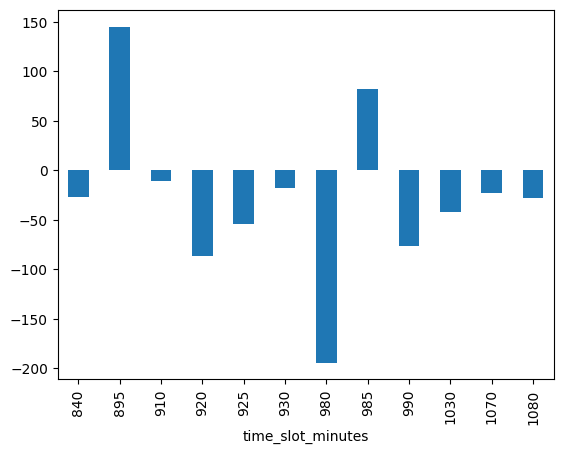

In [114]:
df_results = evening_X_test.copy()
df_results["actual"] = evening_y_test
df_results["predicted"] = evening_y_predict
df_results["error"] = df_results["actual"] - df_results["predicted"]

# Example: error trend by time slot
df_results.groupby("time_slot_minutes")["error"].mean().plot(kind='bar')

In [115]:
evening_model = xgb.XGBRegressor(n_estimators=24)
evening_model.fit(evening_X_train, evening_y_train)
evening_y_predict = evening_model.predict(evening_X_test)
print('XGBRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(evening_y_test, evening_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(evening_y_test, evening_y_predict)}')
print(f'mean squared error = {mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'r2 score = {r2_score(evening_y_test, evening_y_predict)}')

XGBRegressor:

mean absolute error = 62.957275390625
mean absolute percentage error = 0.5561138391494751
mean squared error = 7170.91943359375
root mean squared error = 84.68128204345703
r2 score = 0.8571105599403381


<Axes: xlabel='time_slot_minutes'>

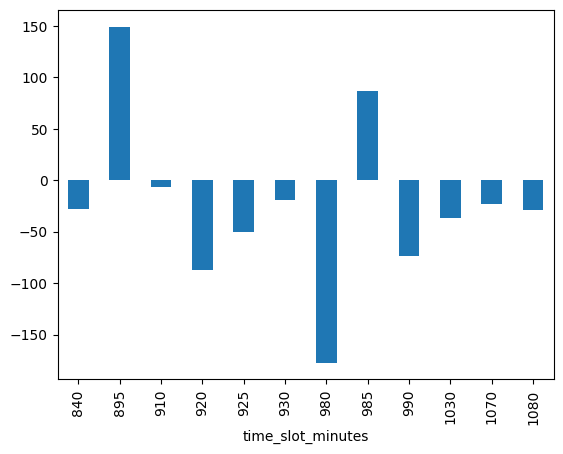

In [116]:
df_results = evening_X_test.copy()
df_results["actual"] = evening_y_test
df_results["predicted"] = evening_y_predict
df_results["error"] = df_results["actual"] - df_results["predicted"]

# Example: error trend by time slot
df_results.groupby("time_slot_minutes")["error"].mean().plot(kind='bar')

In [63]:
time_slot_minutes =[980]
day_encoded = [4]
evening_new_data = pd.DataFrame({'time_slot_minutes': time_slot_minutes, 'day_encoded':day_encoded})
evening_new_pred = evening_model.predict(evening_new_data)

In [64]:
evening_new_pred

array([189.99895], dtype=float32)

XGBRegressor:

mean absolute error = 86.80272674560547
mean absolute percentage error = 1.365376353263855
mean squared error = 16102.703125
root mean squared error = 126.89642333984375
r2 score = 0.6791337132453918


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

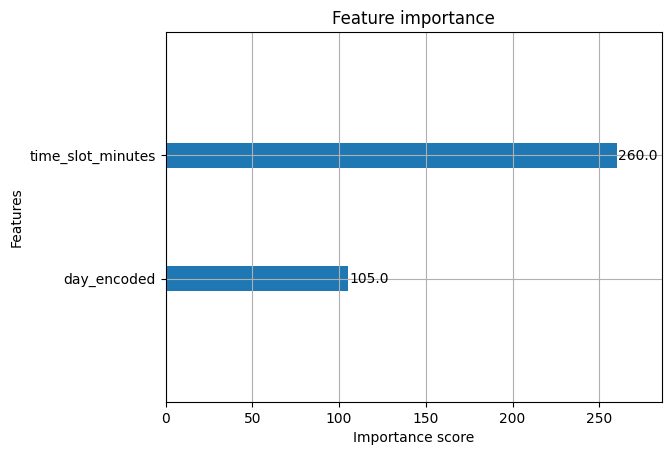

In [65]:
evening_model = xgb.XGBRegressor(
    n_estimators=50,
    learning_rate=0.5,
    max_depth=60,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_alpha=0.3,
    reg_lambda=1.0
)
evening_model.fit(evening_X_train, evening_y_train)
evening_y_predict = evening_model.predict(evening_X_test)
print('XGBRegressor:\n')
print(f'mean absolute error = {mean_absolute_error(evening_y_test, evening_y_predict)}')
print(f'mean absolute percentage error = {mean_absolute_percentage_error(evening_y_test, evening_y_predict)}')
print(f'mean squared error = {mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'root mean squared error = {root_mean_squared_error(evening_y_test, evening_y_predict)}')
print(f'r2 score = {r2_score(evening_y_test, evening_y_predict)}')
from xgboost import plot_importance
plot_importance(evening_model)


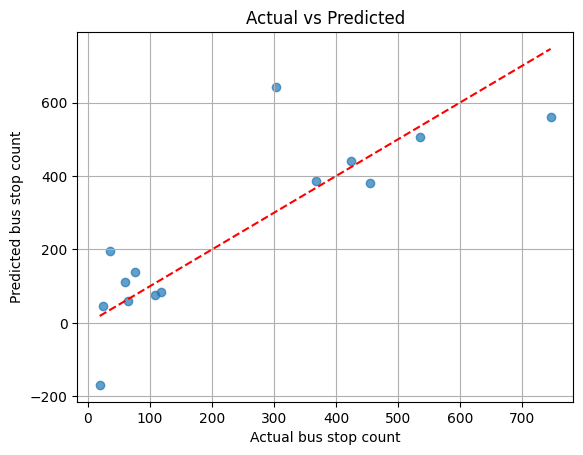

In [66]:
import matplotlib.pyplot as plt

plt.scatter(evening_y_test, evening_y_predict, alpha=0.7)
plt.plot([evening_y_test.min(), evening_y_test.max()], [evening_y_test.min(), evening_y_test.max()], 'r--')
plt.xlabel("Actual bus stop count")
plt.ylabel("Predicted bus stop count")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()


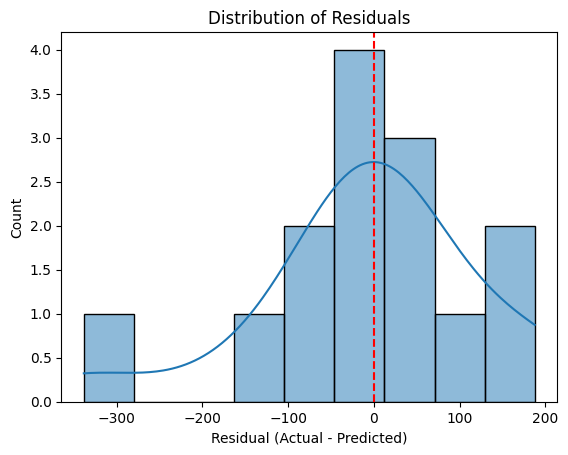

In [67]:
import seaborn as sns
import pandas as pd

residuals = evening_y_test - evening_y_predict
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.axvline(0, color='red', linestyle='--')
plt.show()


In [68]:
print("Mean residual:", residuals.mean())


Mean residual: -8.672978264944893


<Axes: xlabel='time_slot_minutes'>

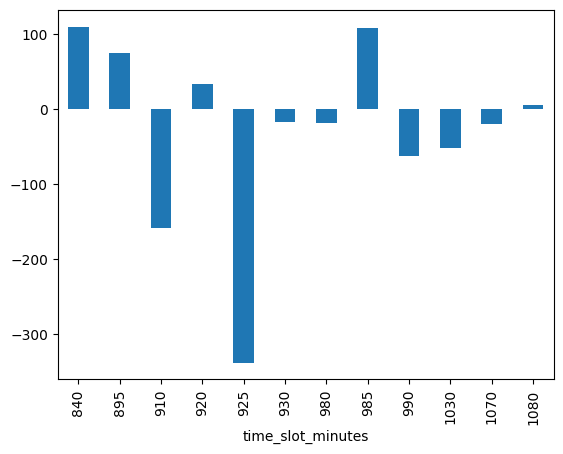

In [69]:
df_results = evening_X_test.copy()
df_results["actual"] = evening_y_test
df_results["predicted"] = evening_y_predict
df_results["error"] = df_results["actual"] - df_results["predicted"]

# Example: error trend by time slot
df_results.groupby("time_slot_minutes")["error"].mean().plot(kind='bar')


In [70]:
time_slot_minutes =[980]
day_encoded = [4]
evening_new_data = pd.DataFrame({'time_slot_minutes': time_slot_minutes, 'day_encoded':day_encoded})
evening_new_pred = evening_model.predict(evening_new_data)

In [71]:
evening_new_pred

array([249.55632], dtype=float32)